# TEST ANGULAR POWER SPECTRA

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM

In [10]:
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'legend.frameon': False,
    'legend.handlelength': 1.5,
})

## 1. Load data

* Cosmology

In [11]:
cosmo = {}
with open('../../data/des-y1-test/cosmological_parameters/values.txt') as cosmo_values:
    for line in cosmo_values:
        if line:
            key, val = line.partition('=')[::2]
            cosmo[key.strip()] = float(val)

In [12]:
cosmo_astropy = FlatLambdaCDM(H0=cosmo['hubble'], Ob0=cosmo['omega_b'], Om0= cosmo['omega_m'], Tcmb0=2.7)

* Distance functions

In [13]:
zdM = np.loadtxt('../../data/des-y1-test/distances/z.txt')
dM = np.loadtxt('../../data/des-y1-test/distances/d_m.txt')

* Matter power spectrum

In [14]:
zp = np.loadtxt('../../data/des-y1-test/matter_power_nl/z.txt')
k_h = np.loadtxt('../../data/des-y1-test/matter_power_nl/k_h.txt')
p_h = np.loadtxt('../../data/des-y1-test/matter_power_nl/p_k.txt')
xp = np.interp(zp, zdM, dM)

#### 1.a. LSST Y10 quantities

Lens sample

In [15]:
nbinlsst = 10
binlsst_a, binlsst_b = np.tril_indices(nbinlsst)
binlsst_a += 1
binlsst_b += 1

In [16]:
import math 
import scipy.integrate as integrate

In [17]:
zph = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.10, 1.20]
def sigma_lens(z):
    return 0.03 * (1 + z)
def dndz(z, z0, alpha):
    return np.square(z) * np.exp( - np.power(z / z0, alpha))
def nz_lens(z, z0, alpha):
    def dndz_lens(z):
        return dndz(z, 0.28, 0.90)
    norm = integrate.quad(lambda z: dndz_lens(z), 0.0, 1100.0 )[0]
    return np.square(z) * np.exp( - np.power(z / z0, alpha)) / norm
def nzi(z, z0, alpha):
    ni = [0.0]*(len(zph) + 1)  
    xi = [0.0]*(len(zph) + 1)
    for j,elem in enumerate(zph):
        xi[j] = (zph[j] - z)/(sigma_lens(z) * np.sqrt(2))
    for k,char in enumerate(zph):
        ni[k] = 0.5*nz_lens(z,z0, alpha)*( math.erf(xi[k+1]) - math.erf(xi[k]))
    return ni

#### 1.b. Matter power spectrum

In [24]:
zp = np.loadtxt('../../data/des-y1-test/matter_power_nl/z.txt')
k_h = np.loadtxt('../../data/des-y1-test/matter_power_nl/k_h.txt')
p_h = np.loadtxt('../../data/des-y1-test/matter_power_nl/p_k.txt')

In [25]:
xp = np.interp(zp, zdM, dM)

In [26]:
k0, kf = k_h[0]*(cosmo['hubble']/100), k_h[-1]*(cosmo['hubble']/100)
k_h2 = np.logspace(np.log10(k0), np.log10(kf), 1024)

In [27]:
k = k_h2*cosmo['h0']

* Unequal-time power spectra

In [28]:
from skypy.power_spectrum import growth_function
import sys

In [29]:
sys.path.append("../../unequalpy")
from matter import matter_power_spectrum_1loop as P1loop
from matter import matter_unequal_time_power_spectrum as Puetc
from approximation import geometric_approx as Pgeom
from approximation import midpoint_approx as Pmid

In [30]:
d = np.loadtxt('../../data/Pfastpt.txt',unpack=True)
ks, pk, p22, p13 = d[:, 0], d[:, 1], d[:, 2], d[:, 3]
p11_int = interp1d( ks, pk, fill_value="extrapolate")
p22_int = interp1d( ks, p22, fill_value="extrapolate")
p13_int = interp1d( ks, p13, fill_value="extrapolate")
powerk = (p11_int, p22_int, p13_int)

In [31]:
g = growth_function(np.asarray(zp), cosmo_astropy)/growth_function(0, cosmo_astropy)

In [32]:
pet = P1loop(k, g, powerk)
puet = Puetc(k, g, g, powerk)
pgeom = Pgeom(pet)
pmid = Pmid(k, g, g, powerk)

## 2. The correlation function

In [33]:
import corfu

In [34]:
r_uet, xi_uet = corfu.ptoxi(k, puet, q=0.2)

In [35]:
r_limb, xi_limb = corfu.ptoxi(k, pet, q=0, limber=True)
r_geom, xi_geom = corfu.ptoxi(k, pgeom, q=0)
r_mid, xi_mid = corfu.ptoxi(k, pmid, q=0)

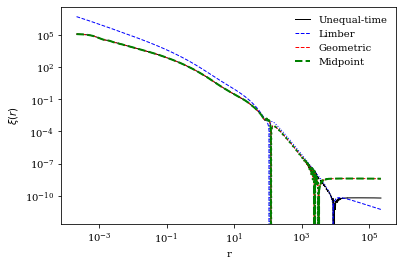

In [36]:
plt.figure(figsize=(6,4))
plt.loglog(r_uet, +xi_uet[0,0], 'k', label='Unequal-time', lw=1)
plt.loglog(r_uet, -xi_uet[0,0], '--k', lw=1)
plt.loglog(r_limb, +xi_limb[0], '--b', label='Limber', lw=1)
plt.loglog(r_limb, -xi_limb[0], ':b', lw=1)
plt.loglog(r_geom, +xi_geom[0,0], '--r', label='Geometric', lw=1)
plt.loglog(r_geom, -xi_geom[0,0], ':r', lw=1)
plt.loglog(r_mid, +xi_mid[0,0], '--g', label='Midpoint', lw=2)
plt.loglog(r_mid, -xi_mid[0,0], ':g', lw=2)

plt.legend()
plt.xlabel('r')
plt.ylabel(r'$\xi(r)$')
plt.show()

## 3. Lensing filters

In [37]:
from lens_filter import filter_galaxy_clustering

* Redshift distribution of galaxies

In [38]:
zn = np.loadtxt('../../data/des-y1-test/nz_lens/z.txt')
nz = [np.loadtxt('../../data/des-y1-test/nz_lens/bin_%d.txt' % i) for i in range(1, 5+1)]

In [39]:
xf = np.interp(zn, zdM, dM)

In [40]:
nzlsst = np.zeros((len(zn),(len(zph) + 1)))
for i in range(0,len(zn)):
    nzlsst[i] = nzi(zn[i], 0.28, 0.90)

* Galaxy clustering

In [42]:
g0 = growth_function(0, cosmo_astropy)
Dz = growth_function(zph, cosmo_astropy) / g0

In [61]:
bias_lsst = 0.95 / Dz   

In [45]:
fglsst = [filter_galaxy_clustering(xf, zn, nzlsst[:,i], bias_lsst[i], cosmo_astropy) for i in range(10)]

## 4. Angular correlation function

In [46]:
theta = np.logspace(-3, np.log10(np.pi), 64)
theta_arcmin = np.degrees(theta)*60

In [51]:
w_limb = [corfu.eqt(theta, (xf, fglsst[a-1]*fglsst[b-1]), (xp, r_limb, xi_limb)) for a, b in zip(binlsst_a, binlsst_b)]

In [52]:
w_geom = [corfu.uneqt(theta, (xf, fglsst[a-1]), (xf, fglsst[b-1]), (xp, xp, r_geom, xi_geom), 1) for a, b in zip(binlsst_a, binlsst_b)]

100%|██████████| 125/125 [00:02<00:00, 59.11it/s]


In [53]:
w_uet = [corfu.uneqt(theta, (xf, fglsst[a-1]), (xf, fglsst[b-1]), (xp, xp, r_uet, xi_uet), True) for a, b in zip(binlsst_a, binlsst_b)]

100%|██████████| 125/125 [00:02<00:00, 61.33it/s]


In [54]:
w_mid = [corfu.uneqt(theta, (xf, fglsst[a-1]), (xf, fglsst[b-1]), (xp, xp, r_mid, xi_mid), True) for a, b in zip(binlsst_a, binlsst_b)]

100%|██████████| 125/125 [00:02<00:00, 58.74it/s]


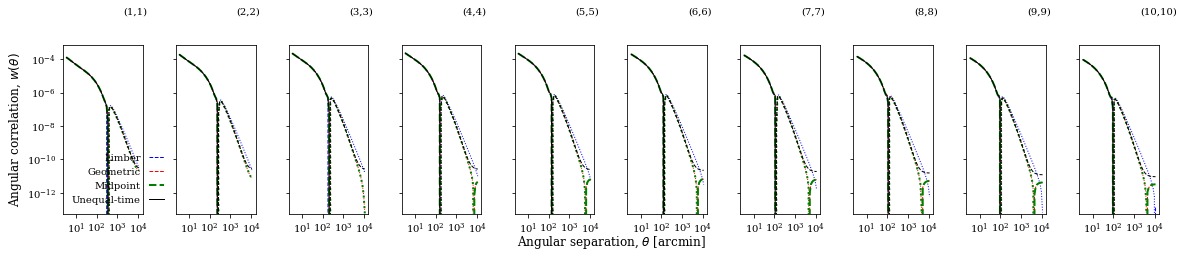

In [55]:
fig, axes = plt.subplots(1,10, figsize=(17, 4), sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for i, (a, b) in enumerate(zip(binlsst_a, binlsst_b)):
    if a == b:
        ax = axes[b-1]
        ax.axis('on')
        ax.loglog(theta_arcmin, +w_limb[i], '--b', label='Limber', lw=1)
        ax.loglog(theta_arcmin, -w_limb[i], ':b', lw=1)
        ax.loglog(theta_arcmin, +w_geom[i], '--r', label='Geometric', lw=1)
        ax.loglog(theta_arcmin, -w_geom[i], ':r', lw=1)
        ax.loglog(theta_arcmin, +w_mid[i], '--g', label='Midpoint', lw=2)
        ax.loglog(theta_arcmin, -w_mid[i], ':g', lw=2)
        ax.loglog(theta_arcmin, +w_uet[i], 'k', label='Unequal-time', lw=1)
        ax.loglog(theta_arcmin, -w_uet[i], '--k', lw=1)
    
#         ax.set_xlim(5e0, 1e4)
#         ax.set_ylim(1e-5, 2e-1)
        ax.set_xticks([1e1, 1e2, 1e3, 1e4])
        ax.tick_params(axis='y', which='minor', labelcolor='none')
        string = '({0},{1})'.format(a,b)
        ax.text(2e3,5e-2,string)

axes[0].legend(markerfirst=False, loc='lower left', frameon=False)

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'Angular separation, $\theta$ [arcmin]', size=12)
ax.set_ylabel(r'Angular correlation, $w(\theta)$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=15)

fig.tight_layout(pad=0.5)

# fig.savefig('plots/w_galaxy_clustering.pdf', bbox_inches='tight')


plt.show()

## 5. Angular power spectrum analysis

### 5.1. Angular power spectra

In [56]:
l_limb, cl_limb = np.transpose([corfu.wtocl(theta, w, lmax=2000) for w in w_limb], (1, 0, 2))

In [57]:
l_geom, cl_geom = np.transpose([corfu.wtocl(theta, w, lmax=2000) for w in w_geom], (1, 0, 2))

In [58]:
l_uet, cl_uet = np.transpose([corfu.wtocl(theta, w, lmax=2000) for w in w_uet], (1, 0, 2))

In [59]:
l_mid, cl_mid = np.transpose([corfu.wtocl(theta, w, lmax=2000)for w in w_mid], (1, 0, 2))

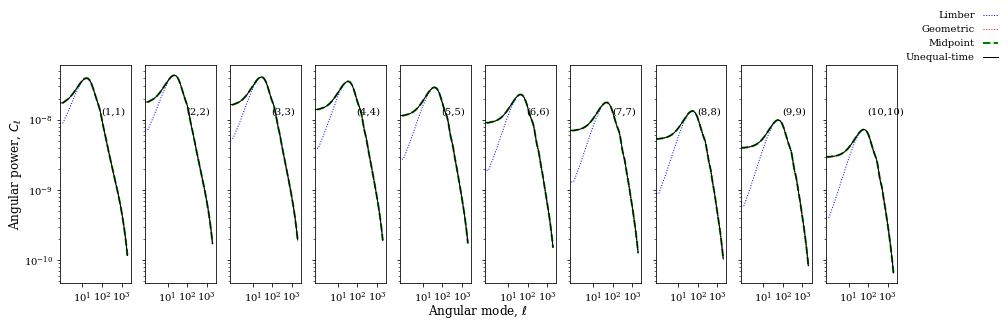

In [88]:
fig, axes = plt.subplots(1,10, figsize=(15,4), sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for i, (a, b) in enumerate(zip(binlsst_a, binlsst_b)):
    if a == b:
        ax = axes[b-1]
        ax.axis('on')
        ax.loglog(l_limb[i], cl_limb[i], ':b', label='Limber', lw=1)
        ax.loglog(l_geom[i], cl_geom[i], ':r', label='Geometric', lw=1) 
        ax.loglog(l_mid[i], cl_mid[i], '--g', label='Midpoint', lw=2)
        ax.loglog(l_uet[i], cl_uet[i], 'k', label='Unequal-time', lw=1)
        
#         ax.set_xlim(5e0, 2e3)
#         ax.set_ylim(2e-7, 3e-4)
        ax.set_xticks([1e1, 1e2, 1e3])
        string = '({0},{1})'.format(a,b)
        ax.text(0.9e2,1.2e-8,string)

axes[0].legend(markerfirst=False, bbox_to_anchor=(0.9, 1.1), bbox_transform=plt.gcf().transFigure, loc='upper left')

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'Angular mode, $\ell$', size=12)
ax.set_ylabel(r'Angular power, $C_{\ell}$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=12)

# fig.tight_layout(pad=0.5)

# fig.savefig('plots/cl_galaxy_clustering.pdf', bbox_inches='tight')

plt.show()

### 5.2. Relative error

In [63]:
frac_limb = cl_limb/cl_uet 
frac_geom = cl_geom/cl_uet
frac_mid = cl_mid/cl_uet
frac_uet = cl_uet/cl_uet

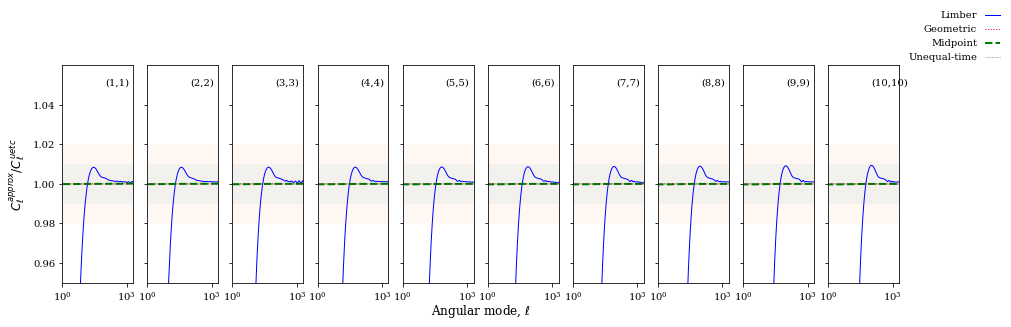

In [94]:
fig, axes = plt.subplots(1,10, figsize=(15,4), sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for i, (a, b) in enumerate(zip(binlsst_a, binlsst_b)):
    if a == b:
        ax = axes[b-1]
        ax.axis('on')
        ax.semilogx(l_limb[i], frac_limb[i], 'b', label='Limber', lw=1)
        ax.semilogx(l_geom[i], frac_geom[i], ':r', label='Geometric', lw=1) 
        ax.semilogx(l_mid[i], frac_mid[i], '--g', label='Midpoint', lw=2)
        ax.semilogx(l_uet[i], frac_uet[i], ':k', label='Unequal-time', lw=0.5)
    
        ax.set_xlim(1, 2e3)
        ax.set_ylim(0.95, 1.06)
        ax.set_yticks([0.96, 0.98, 1, 1.02, 1.04])
        string = '({0},{1})'.format(a,b)
        ax.text(1e2,1.05,string)
        ax.fill_between(l_limb[0], 0.99, 1.01, alpha=0.05)
        ax.fill_between(l_limb[0], 0.98, 1.02, alpha=0.05)


axes[0].legend(markerfirst=False, bbox_to_anchor=(0.9, 1.1), bbox_transform=plt.gcf().transFigure, loc='upper left')

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'Angular mode, $\ell$', size=12)
ax.set_ylabel(r'$C_{\ell}^{approx} / C_{\ell}^{uetc}$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=12)

# fig.tight_layout(pad=0.5)

# fig.savefig('plots/fraction_cl_clustering.pdf', bbox_inches='tight')

plt.show()

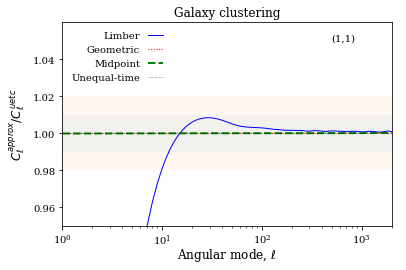

In [95]:
fig, axes = plt.subplots(1,1, figsize=(6,4), sharex=True, sharey=True)

ax = axes
ax.axis('on')
ax.semilogx(l_limb[0], frac_limb[0], 'b', label='Limber', lw=1)
ax.semilogx(l_geom[0], frac_geom[0], ':r', label='Geometric', lw=1) 
ax.semilogx(l_mid[0], frac_mid[0], '--g', label='Midpoint', lw=2)
ax.semilogx(l_uet[0], frac_uet[0], ':k', label='Unequal-time', lw=0.5)
    
ax.set_xlim(1, 2e3)
ax.set_ylim(0.95, 1.06)
ax.set_yticks([0.96, 0.98, 1, 1.02, 1.04])
string = '({0},{1})'.format(1,1)
ax.text(5e2,1.05,string)
ax.fill_between(l_limb[0], 0.99, 1.01, alpha=0.05)
ax.fill_between(l_limb[0], 0.98, 1.02, alpha=0.05)


axes.legend(markerfirst=False, loc='upper left')

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'Angular mode, $\ell$', size=12)
ax.set_ylabel(r'$C_{\ell}^{approx} / C_{\ell}^{uetc}$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=12)
ax.set_title('Galaxy clustering')

fig.tight_layout(pad=0.5)

# fig.savefig('plots/bin11_cl_clustering.pdf', bbox_inches='tight')

plt.show()